### COSC102 Assignment 3 - Prepare Data
The purpose of this notebook is to prepare the data for the model training.
We will use the data from the IMU sensor to train a model to predict the activity of the user.



In [1]:
# imports

import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import dtreeviz

In [2]:



# Set some lists to store the IMU data.

time_track = []
ax_set = []
ay_set = []
az_set = []

gx_set = []
gy_set = []
gz_set = []

activity_set = []

def map_activity(activity_string):
    if activity_string == 'Standing':
        return 0
    elif activity_string == 'Walking':
        return 1
    elif activity_string == 'Jogging':
        return 2
    elif activity_string == 'Side-Step':
        return 3
    elif activity_string == 'Running':
        return 4


In [3]:
# Read the IMU data from the csv file.
with open ('./datasets/a3_imu_data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        time_track.append(float(row[0]));
        ax_set.append(float(row[1]))
        ay_set.append(float(row[2]))
        az_set.append(float(row[3]))
        gx_set.append(float(row[4]))
        gy_set.append(float(row[5]))
        gz_set.append(float(row[6]))

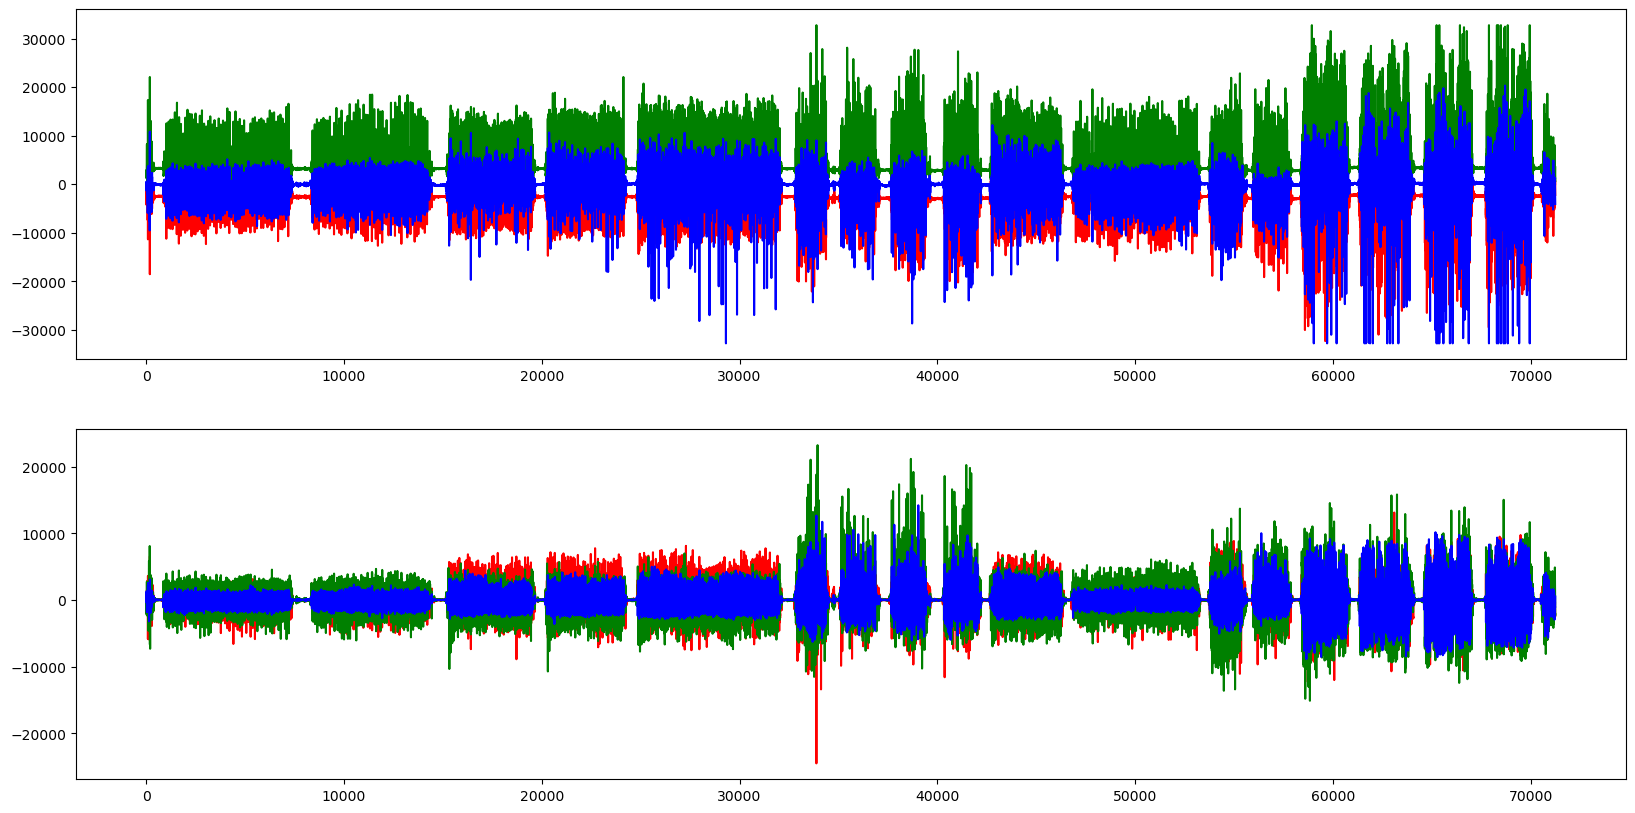

In [4]:
# Check the raw IMU data from the csv file.

fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')

start_ts:  1598240221.0


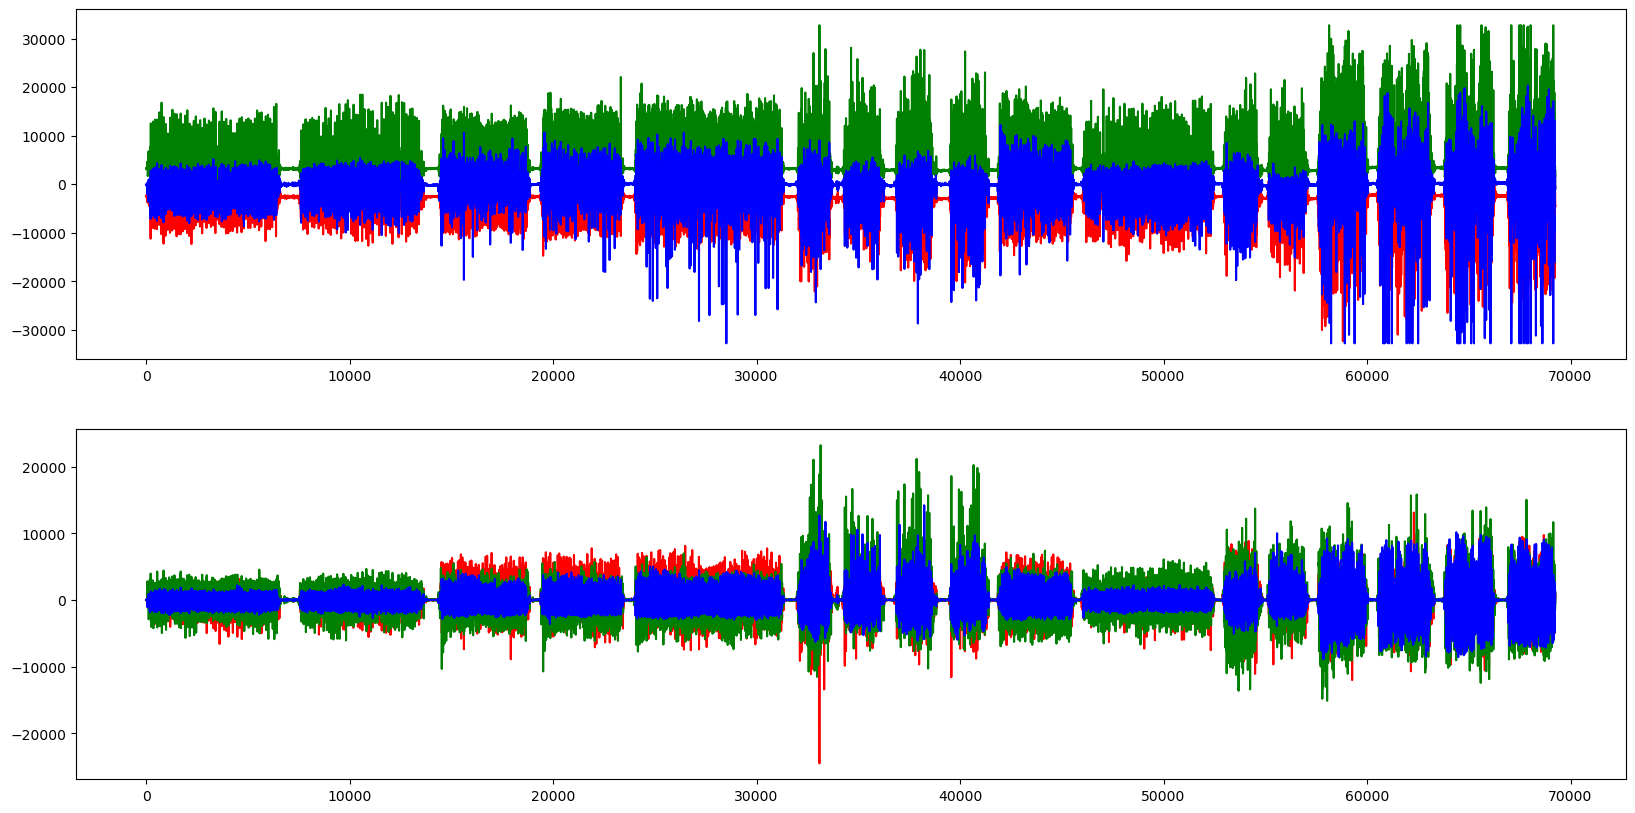

In [5]:
start_idx = 800

start_ts = time_track[start_idx]
print('start_ts: ', start_ts)

end_idx = time_track.index(start_ts + 711)

# Sanity Check
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set[start_idx:end_idx], color='r')
axs[0].plot(ay_set[start_idx:end_idx], color='g')
axs[0].plot(az_set[start_idx:end_idx], color='b')

axs[1].plot(gx_set[start_idx:end_idx], color='r')
axs[1].plot(gy_set[start_idx:end_idx], color='g')
axs[1].plot(gz_set[start_idx:end_idx], color='b')

In [6]:

# Add activity annotation to the IMU data from the csv file.
with open ('./datasets/a3_activity_annotations.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # skip the headers
    for row in reader:
        time_stamp = (row[0].split('='))[1]
        activity_set.append([float(time_stamp),row[-1], map_activity(row[-1])])

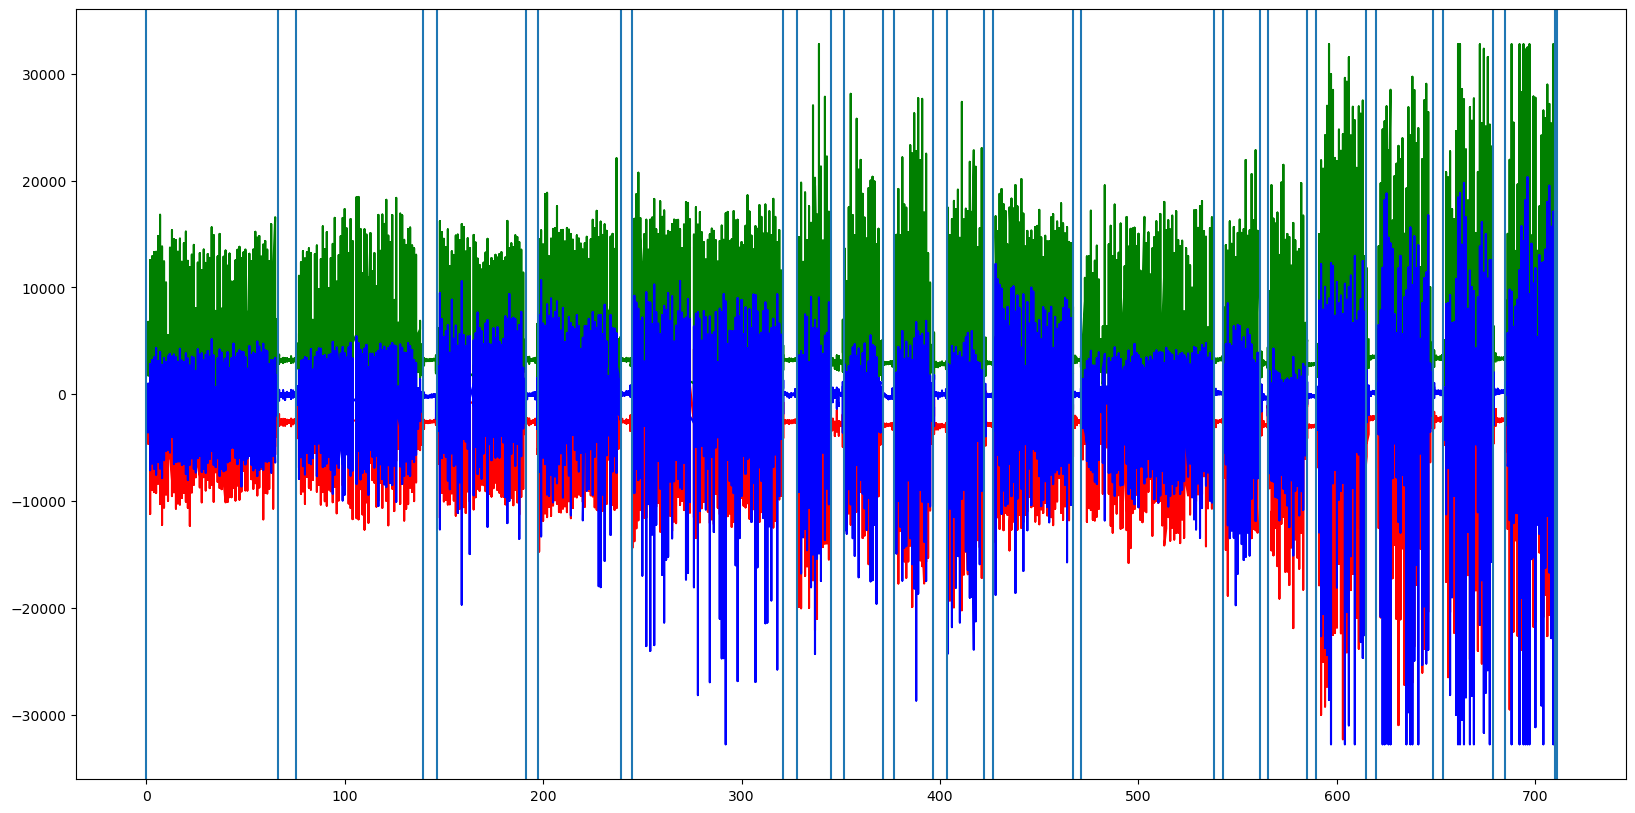

In [7]:
# Now we can create an activity time track for each data point within
# the imu timeseries. We will have a list to store the numeric code and the string.
activity_timeseries = [];
activity_string_timeseries = [];
activity_idx = 0;

# We need the time stamp for the start point
start_time = time_track[start_idx]

# The time track segment we are interested in 
time_track_segment = time_track[start_idx:end_idx]

# #Add an 'end' activity - this book-ends the data
activity_set.append([time_track_segment[-1]-start_time, 'Standing'])

# Zero out the time track segment to make it match the video time
time_track_segment = np.array(time_track_segment)-start_time

ig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_track_segment,ax_set[start_idx:end_idx], color='r')
ax.plot(time_track_segment,ay_set[start_idx:end_idx], color='g')
ax.plot(time_track_segment,az_set[start_idx:end_idx], color='b')


for imu_time_track_item in time_track_segment:
    current_time =  imu_time_track_item
    next_activity_ts = activity_set[activity_idx+1][0]
    
    # Here we need to move to the next activity in the annotations data if the current
    # IMU data point lies after the next annotation time stamp.
    if current_time > next_activity_ts:
        #Move to nex activity
        activity_idx = activity_idx + 1;
        next_activity_ts = activity_set[activity_idx+1][0]
    
    
    activity_timeseries.append(activity_set[activity_idx][2])
    activity_string_timeseries.append(activity_set[activity_idx][1])

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act))

(array([ 8892., 19341., 19496., 11303., 10218.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

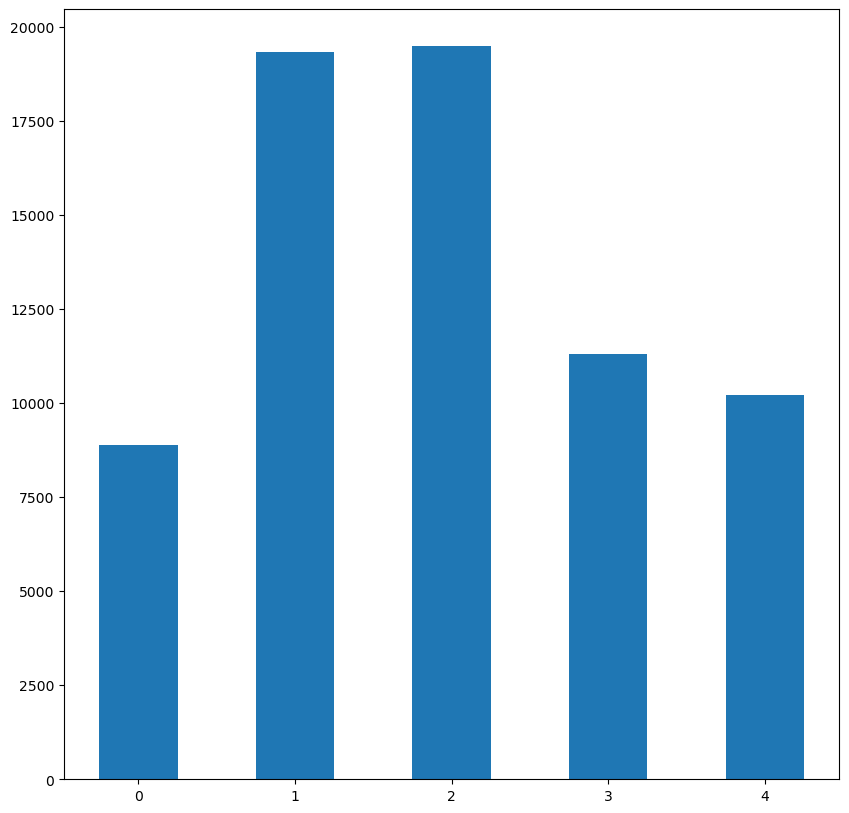

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(activity_timeseries, bins=[-0.5,0.5,1.5,2.5,3.5, 4.5] , rwidth=0.5, align='mid')

In [9]:
#We are only interested in the video window
ax_set = ax_set[start_idx:end_idx]
ay_set = ay_set[start_idx:end_idx]
az_set = az_set[start_idx:end_idx]
gx_set = gx_set[start_idx:end_idx]
gy_set = gy_set[start_idx:end_idx]
gz_set = gz_set[start_idx:end_idx]

In [10]:
# Now we can start working on the machine learning workflow.
# The first step is to calculate some feature that we can use.
# We will base our analysis around a moving window across the
# the timeseries data. This involves taking a fixed length window, based upon the time, and
# sliding it across the data.
# To keep thing simple, we will start with a 1 second window with no overlapping
# data points

feature_set = []
target_set  = []            
window_size = 1.0;
bad_data_point = [104, 105, 163, 164, 274, 275]            

for t in range(int(time_track_segment[0]),int(time_track_segment[-1])):
    
    #There is a missing data-point (probably due to a bad segment on the SD card)
    
    if t in bad_data_point:
      continue
    
    #The index function finds the index of the first occurnace of the data
    window_start_idx = list(time_track_segment).index(t)
    window_end_idx = list(time_track_segment).index(t+window_size)
    ax_window = ax_set[window_start_idx:window_end_idx]
    ay_window = ay_set[window_start_idx:window_end_idx]
    az_window = az_set[window_start_idx:window_end_idx]
    gx_window = gx_set[window_start_idx:window_end_idx]
    gy_window = gy_set[window_start_idx:window_end_idx]
    gz_window = gz_set[window_start_idx:window_end_idx]

    #activity that will be assigned to the set of features
    activity_code = activity_timeseries[window_start_idx]

    # Now we can build features from the data window
    # Mean
    mu_ax = statistics.mean(ax_window)
    mu_ay = statistics.mean(ay_window)
    mu_az = statistics.mean(az_window)
    mu_gx = statistics.mean(gx_window)
    mu_gy = statistics.mean(gy_window)
    mu_gz = statistics.mean(gz_window)
    
    # Max
    max_ax = max(ax_window)
    max_ay = max(ay_window)
    max_az = max(az_window)
    max_gx = max(gx_window)
    max_gy = max(gy_window)
    max_gz = max(gz_window)
    
    # Min
    min_ax = min(ax_window)
    min_ay = min(ay_window)
    min_az = min(az_window)
    min_gx = min(gx_window)
    min_gy = min(gy_window)
    min_gz = min(gz_window)
    
    ax_abs_sum = 0
    ay_abs_sum = 0
    az_abs_sum = 0
    
    gx_abs_sum = 0
    gy_abs_sum = 0
    gz_abs_sum = 0
    
    a_sum_sq = 0
    g_sum_sq = 0
    
    # Here we need to accumulate the values to calculate the SMA and AI
    for i in range(0, len(ax_window)):
        
        # Add up the absolute values for the SMA
        ax_abs_sum = ax_abs_sum + abs(ax_window[i])
        ay_abs_sum = ay_abs_sum + abs(ay_window[i])
        az_abs_sum = az_abs_sum + abs(az_window[i])
        
        gx_abs_sum = gx_abs_sum + abs(gx_window[i])
        gy_abs_sum = gy_abs_sum + abs(gy_window[i])
        gz_abs_sum = gz_abs_sum + abs(gz_window[i])
        
        
        a_sum_sq = ((ax_window[i]**2) + (ay_window[i]**2) + (az_window[i]**2)) + a_sum_sq
        g_sum_sq = ((gx_window[i]**2) + (gy_window[i]**2) + (gz_window[i]**2)) + g_sum_sq
    
    # Signal Magnitude area    
    a_sma = (ax_abs_sum + ay_abs_sum + az_abs_sum) / len(ax_window)
    g_sma = (gx_abs_sum + gy_abs_sum + gz_abs_sum) / len(ax_window)

    # Average intensity
    a_av_intensity = math.sqrt(a_sum_sq) / len(ax_window)
    g_av_intensity = math.sqrt(g_sum_sq) / len(ax_window)


    feature_row = [mu_ax, mu_ay, mu_az, mu_gx, mu_gy, mu_gz, \
                   max_ax, max_ay, max_az, max_gx, max_gy, max_gz, \
                   min_ax, min_ay, min_az, min_gx, min_gy, min_gz, \
                   a_sma, g_sma, a_av_intensity, g_av_intensity]

    feature_set.append(feature_row)
    target_set.append(activity_code)

    feature_names = ['mu_ax', 'mu_ay', 'mu_az', 'mu_gx', 'mu_gy', 'mu_gz', \
                    'max_ax', 'max_ay', 'max_az', 'max_gx', 'max_gy', 'max_gz', \
                    'min_ax', 'min_ay', 'min_az', 'min_gx', 'min_gy', 'min_gz', \
                    'a_sma', 'g_sma', 'a_av_intensity', 'g_av_intensity']
                    



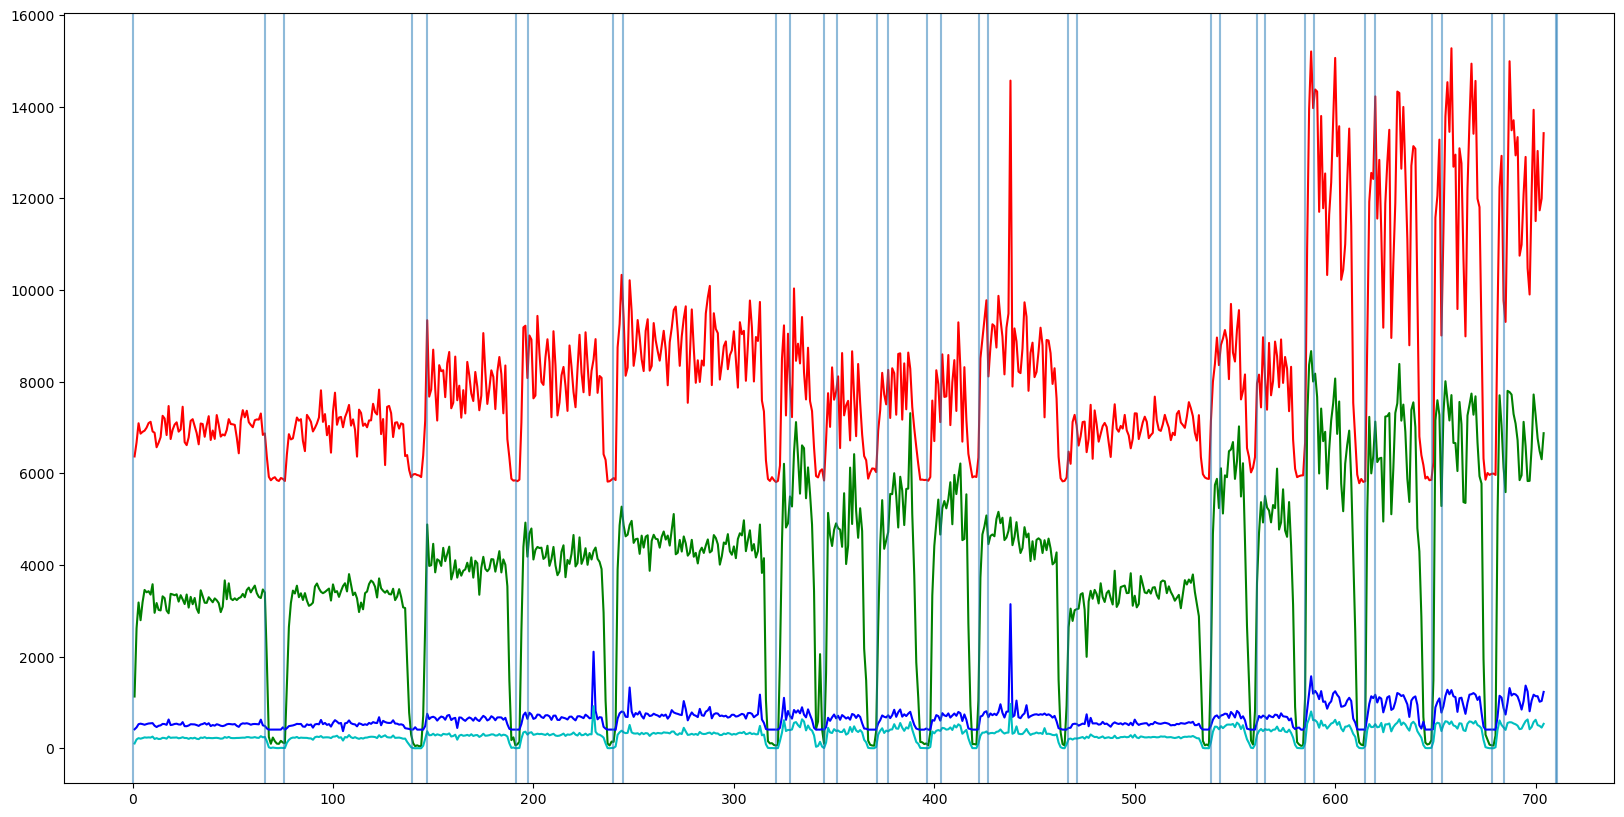

In [11]:
# Lets visualise some of the features just out of interest - we will look at the SMA and AI
plot_range = range(1,705)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(plot_range,np.array(feature_set)[:,18], color='r')
ax.plot(plot_range,np.array(feature_set)[:,19], color='g')
ax.plot(plot_range,np.array(feature_set)[:,20], color='b')
ax.plot(plot_range,np.array(feature_set)[:,21], color='c')

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act), alpha=0.5)
    

### Decision Tree Classifier

In [12]:
# Test and Train split
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, test_size=0.2, random_state=42)


In [13]:
# Decision Tree Classifier - Optimise a hyperparameter - max_depth

best_max_depth = 1
best_mean_f1 = 0
f1_set = np.zeros(11)
max_depth_range = range(1,11)

for depth in max_depth_range:

  clf = DecisionTreeClassifier(max_depth=depth, random_state=42).fit(X_train, y_train)
  # Return the predictions for the 5-Fold crossvalidation
  y_predicted = cross_val_predict(clf, X_train,y_train, cv=5)

  # Test
  f1_set[depth] = np.mean(f1_score(y_train,y_predicted,average=None))
  current_f1 = np.mean(f1_score(y_train,y_predicted,average=None))
  
  if current_f1 > best_mean_f1:
    best_mean_f1 = current_f1
    best_depth = depth
    best_clf = clf


Best depth:  5
Best F1 score:  0.9072647935880769


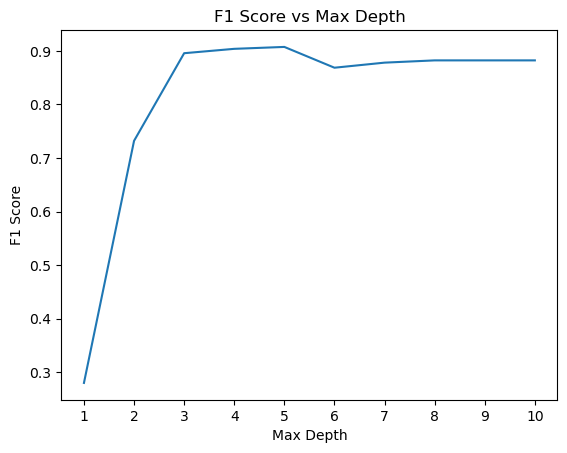

In [14]:
# Plot the F1 score vs the max depth

print("Best depth: ", best_depth)
print("Best F1 score: ", best_mean_f1)

plt.plot(max_depth_range, f1_set[1:])
plt.xlabel('Max Depth')
plt.xticks(np.arange(1, 11, 1))
plt.ylabel('F1 Score')
plt.title('F1 Score vs Max Depth')
plt.show()

Test Recall: [0.94736842 0.95555556 0.925      0.79166667 1.        ]
Test Precision: [0.9        0.95555556 0.97368421 0.9047619  0.76470588]
Test F1 Score: [0.92307692 0.95555556 0.94871795 0.84444444 0.86666667]


/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


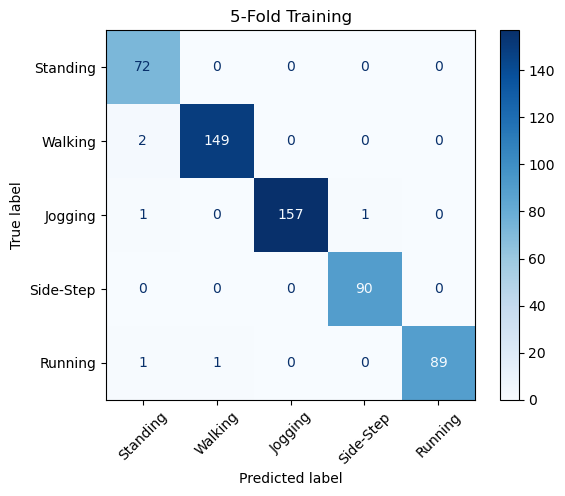

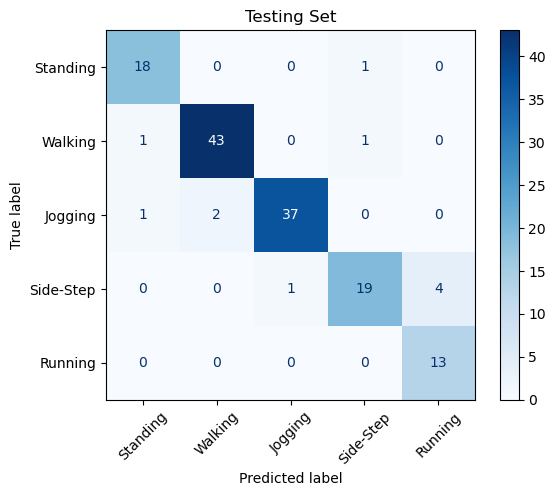

In [15]:
# Return the predictions for the 5-Fold crossvalidation
y_predicted = cross_val_predict(best_clf, X_train,y_train, cv=5)
# Return the predictions for the test set
y_test_predicted = best_clf.predict(X_test)

display_labels = ['Standing', 'Walking','Jogging', 'Side-Step','Running']

# Plot the confusion matrices using the pretty functions
fig, ax = plt.subplots()
disp = plot_confusion_matrix(best_clf, X_train, y_train,
                                 display_labels=display_labels,
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('5-Fold Training')

fig, ax = plt.subplots()
disp = plot_confusion_matrix(best_clf, X_test, y_test,
                                 display_labels=display_labels,
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('Testing Set')

# Test Recall, Precision and F1 Score
print("Test Recall:",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:",f1_score(y_test,y_test_predicted,average=None))


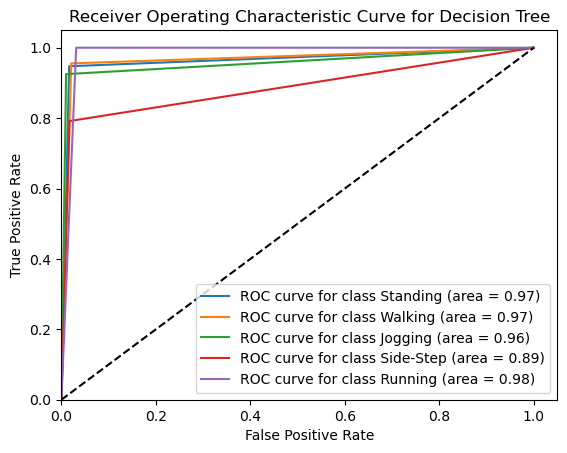

In [16]:
# Find the ROC and AUC for each class
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_test_predicted_bin = label_binarize(y_test_predicted, classes=[0, 1, 2, 3, 4])

n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_predicted_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
fig, ax = plt.subplots()
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='ROC curve for class {0} (area = {1:0.2f})'
                                   ''.format(display_labels[i], roc_auc[i]))
    
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic Curve for Decision Tree')
ax.legend(loc="lower right")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


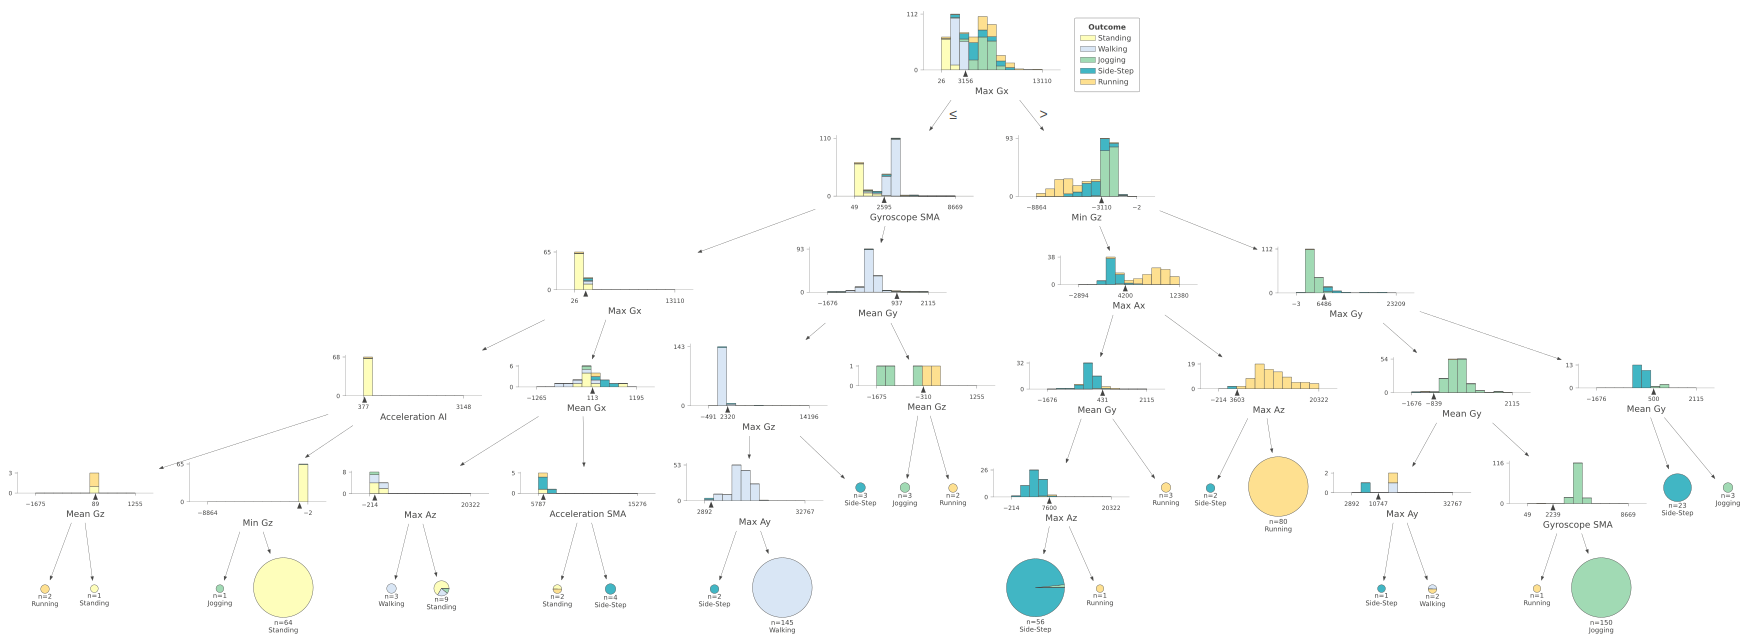

In [17]:
# visualise the best classifier using dtreeviz
c_names = {0:"Standing", 1:"Walking", 2:"Jogging", 3:"Side-Step", 4:"Running"}
f_names = ["Mean Ax", "Mean Ay", "Mean Az","Mean Gx", "Mean Gy", "Mean Gz",
           "Max Ax", "Max Ay", "Max Az","Max Gx", "Max Gy", "Max Gz", 
           "Min Ax", "Min Ay", "Min Az","Min Gx", "Min Gy", "Min Gz",
           "Acceleration SMA", "Gyroscope SMA" , "Acceleration AI", "Gyroscope AI"]

viz = dtreeviz.model(best_clf,
      np.array(X_train),
      np.array(y_train),
      target_name ='Outcome',
      feature_names = f_names,
      class_names = c_names
      )
viz.view()

### K Nearest Neighbours

In [18]:
knn_features_set = np.array(feature_set)
knn_target_set = np.array(target_set)

#Normalisation of data to minimize outliers
knn_features_set = preprocessing.MinMaxScaler().fit_transform(knn_features_set)

# Test and Train split
X_train, X_test, y_train, y_test = train_test_split(knn_features_set, target_set, test_size=0.2, random_state=42)

K:  3
F1 Score: [0.8630137  0.94230769 0.9689441  0.95402299 0.91860465]
Accuracy: 93.78330373001776%
Mean squared error:  35.52397868561279%
K:  4
F1 Score: [0.8961039  0.95454545 0.95705521 0.93567251 0.91017964]
Accuracy: 93.78330373001776%
Mean squared error:  34.63587921847247%
K:  5
F1 Score: [0.90196078 0.95145631 0.96       0.93567251 0.91666667]
Accuracy: 93.96092362344582%
Mean squared error:  32.682060390763766%
K:  6
F1 Score: [0.89032258 0.95114007 0.94801223 0.93023256 0.8969697 ]
Accuracy: 93.07282415630551%
Mean squared error:  37.12255772646537%
K:  7
F1 Score: [0.8961039  0.94498382 0.95384615 0.92397661 0.91017964]
Accuracy: 93.25044404973357%
Mean squared error:  35.52397868561279%
K:  8
F1 Score: [0.88461538 0.94498382 0.94512195 0.93491124 0.8902439 ]
Accuracy: 92.71758436944938%
Mean squared error:  36.9449378330373%
K:  9
F1 Score: [0.89171975 0.94498382 0.95092025 0.92857143 0.90361446]
Accuracy: 93.07282415630551%
Mean squared error:  36.05683836589698%
K:  10

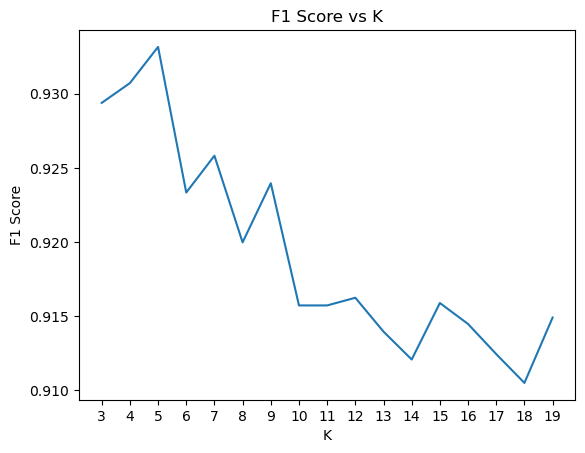

In [19]:
# Optimisation of k using accuracy score
    # Also includes mean squared error

best_k = 0
best_mean_f1 = 0
f1_set = np.zeros(20)
best_k_range = range(3,20) # remove k = 1 and 2 as they are outliers and cause overfitting

for k in best_k_range:
   #uses p = 1 for distance
  clf = neighbors.KNeighborsClassifier(k, weights='uniform', p=1).fit(X_train, y_train)
  # Return the predictions for the 5-Fold crossvalidation
  y_predicted = cross_val_predict(clf, X_train,y_train, cv=5)

  # Print out the recall, precision and F1 scores
  print("K: ", k)
  print("F1 Score:",f1_score(y_train,y_predicted,average=None))
  print("Accuracy:",str(accuracy_score(y_train, y_predicted)*100)+"%")
  print("Mean squared error: ",str(np.mean((y_train - y_predicted) ** 2)*100)+"%") 

  # Test
  f1_set[k] = np.mean(f1_score(y_train,y_predicted,average=None))
  current_f1 = np.mean(f1_score(y_train,y_predicted,average=None))
  
  if current_f1 > best_mean_f1:
    best_mean_f1 = current_f1
    best_k = k
    best_clf = clf

# Plot the F1 score vs the k value
plt.plot(best_k_range, f1_set[3:20])
plt.xlabel('K')
plt.xticks(np.arange(3, 20, 1))
plt.ylabel('F1 Score')
plt.title('F1 Score vs K')
plt.show()

/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


Text(0.5, 1.0, 'Testing Set')

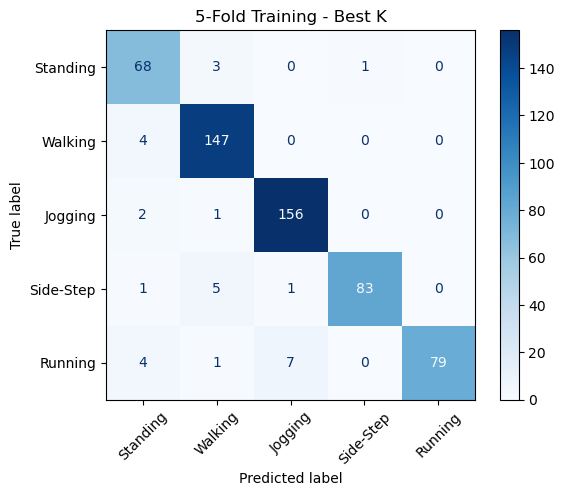

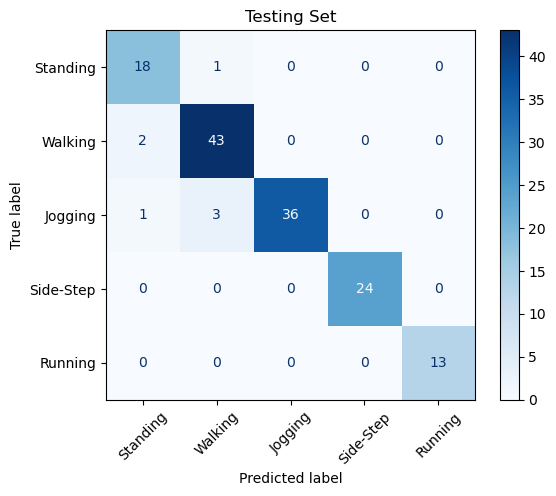

In [20]:
##Plot confusion matrices

# Return the predictions for the 5-Fold crossvalidation
y_predicted = cross_val_predict(best_clf, X_train,y_train, cv=5)

# Construct the confusion matricies
conf_mat_train = confusion_matrix(y_train, y_predicted)

# Plot the confusion matrices
fig, ax = plt.subplots()
disp = plot_confusion_matrix(best_clf, X_train, y_train,
                                 display_labels=['Standing', 'Walking','Jogging', 'Side-Step','Running'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('5-Fold Training - Best K')

fig, ax = plt.subplots()
disp = plot_confusion_matrix(best_clf, X_test, y_test,
                                 display_labels=['Standing', 'Walking','Jogging', 'Side-Step','Running'],
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('Testing Set')

Text(0.5, 1.0, 'Receiver operating characteristic for KNN')

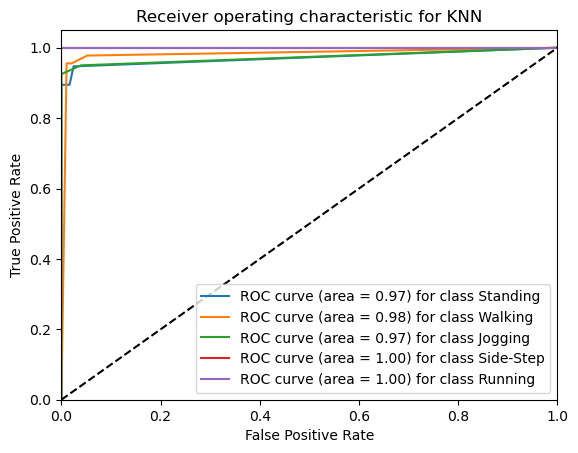

In [21]:
# Calculate the ROC and AUC for each class
y_score = best_clf.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]




fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
fig, ax = plt.subplots()
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], c_names[i]))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")
ax.set_title('Receiver operating characteristic for KNN')




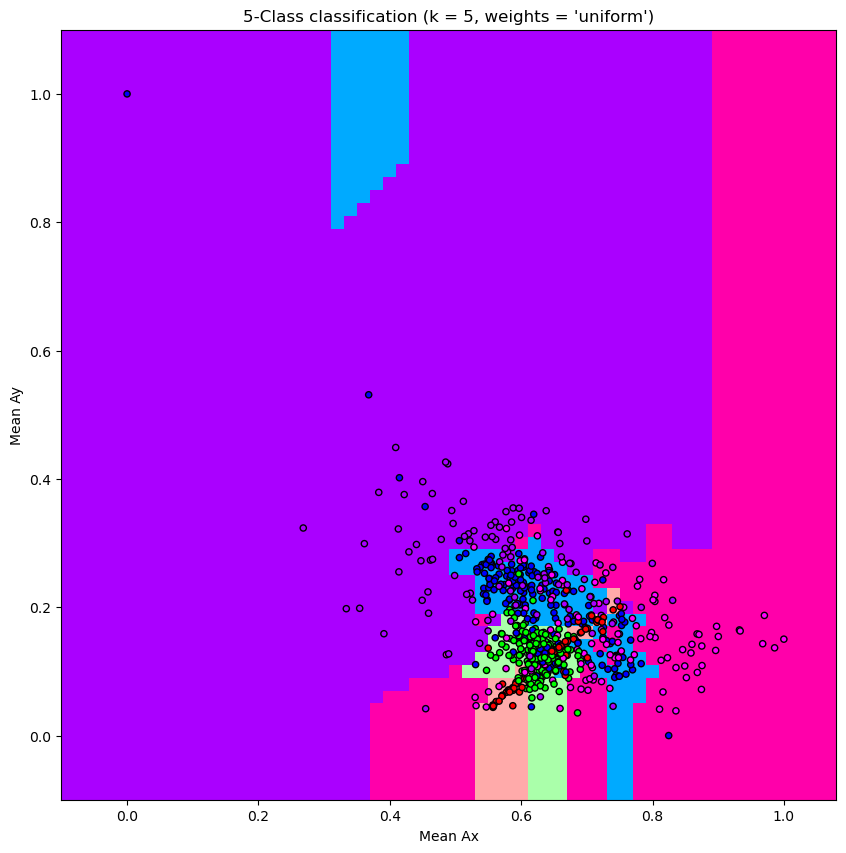

In [22]:
# Plot the decision boundaries for the KNN classifier using the first two features
# This is a 2D plot so we will only use the first two features
X = knn_features_set[:, :2]
y = knn_target_set

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF','#FF00AA','#AA00FF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00','#0000FF','#FF00FF','#AA00FF'])

h = .02  # step size in the mesh

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(best_k, weights='uniform', p=1).fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Mean Ax')
ax.set_ylabel('Mean Ay')
ax.set_title("5-Class classification (k = %i, weights = '%s')"
            % (best_k, 'uniform'))

plt.show()



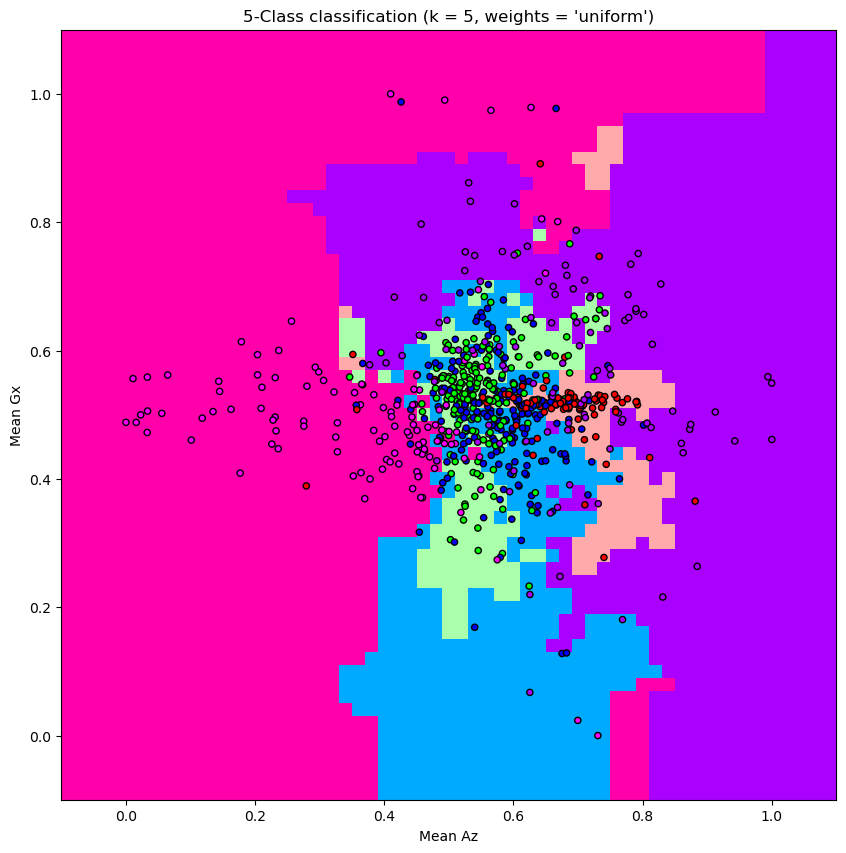

In [23]:
# Plot the decision boundaries for the KNN classifier using two more features

X = knn_features_set[:, 2:4]
y = knn_target_set

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF','#FF00AA','#AA00FF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00','#0000FF','#FF00FF','#AA00FF'])

h = .02  # step size in the mesh

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(best_k, weights='uniform', p=1).fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))   

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Mean Az')
ax.set_ylabel('Mean Gx')
ax.set_title("5-Class classification (k = %i, weights = '%s')"
            % (best_k, 'uniform'))

plt.show()

### SGD Classifier

In [24]:
# standardise mean and std as the SGD classifier will be used.
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std

In [25]:
# check the alpha range for the SGD classifier 
# keep adjusting to hone in on the best value
alpha_range = np.arange(0.0001, 0.00051, 0.00001)
print(alpha_range)

[0.0001  0.00011 0.00012 0.00013 0.00014 0.00015 0.00016 0.00017 0.00018
 0.00019 0.0002  0.00021 0.00022 0.00023 0.00024 0.00025 0.00026 0.00027
 0.00028 0.00029 0.0003  0.00031 0.00032 0.00033 0.00034 0.00035 0.00036
 0.00037 0.00038 0.00039 0.0004  0.00041 0.00042 0.00043 0.00044 0.00045
 0.00046 0.00047 0.00048 0.00049 0.0005 ]


In [26]:
#initialise highest performing variables
best_performance = 0
best_f1 = 0
best_f2 = 0
best_alpha = 0
f1_set = np.zeros(len(alpha_range))
i = 0

# loop through and store all of the 2 most higher performing features for each alpha
for alpha in alpha_range:


    clf = SGDClassifier(alpha=alpha, random_state=42)
    clf.fit(X_train, y_train)

    # Return the predictions for the 3-Fold crossvalidation
    y_predicted = cross_val_predict(
        clf, X_train, y_train)

    # Store the result
    current_f1 = np.mean(f1_score(y_train, y_predicted, average=None))
    f1_set[i] = current_f1
    
    if current_f1 > best_performance:
        best_performance = current_f1
        best_clf = clf
        best_alpha = alpha
    i = i + 1

In [27]:
# standardise the the mean value of X_test as it must be fit into the best SGD in previous step.
X_test = (X_test - mean) / std
y_test_predicted = best_clf.predict(X_test)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# calculate recall, precision and F1 scores for each class
print("Recall Score:", recall_score(y_train,y_predicted,average=None))
print("Precision Score:", precision_score(y_train,y_predicted,average=None))
print("F1 Score:", f1_score(y_train,y_predicted,average=None))
print("Best alpha:", best_alpha)

Recall Score: [0.86111111 0.94701987 0.98742138 0.9        0.91208791]
Precision Score: [0.91176471 0.92857143 0.97515528 0.93103448 0.89247312]
F1 Score: [0.88571429 0.93770492 0.98125    0.91525424 0.90217391]
Best alpha: 0.00012


Text(0.5, 1.0, 'Best classified F1 Scores')

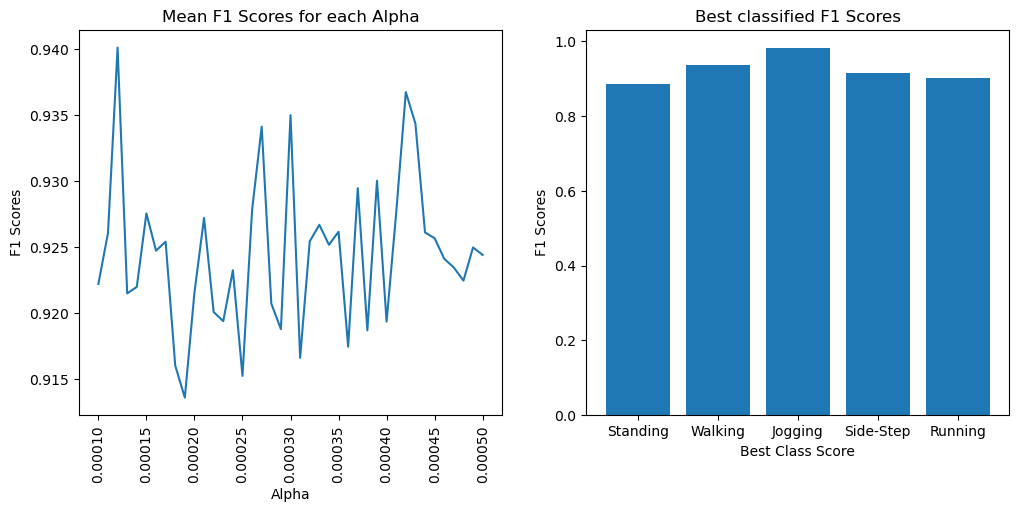

In [28]:
# Plot f1_scores for each iteration
target_names = ['Standing', 'Walking','Jogging', 'Side-Step','Running']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
ax1.plot(alpha_range, f1_set)
ax1.set_xlabel('Alpha')
ax1.set_ylabel('F1 Scores')
ax1.set_title('Mean F1 Scores for each Alpha')

for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.plot()


ax2.bar(target_names, f1_score(y_train,y_predicted,average=None))
ax2.set_xlabel('Best Class Score')
ax2.set_ylabel('F1 Scores')
ax2.set_title('Best classified F1 Scores')


/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
/home/squid/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


Text(0.5, 1.0, 'Test Data Confusion Matrix')

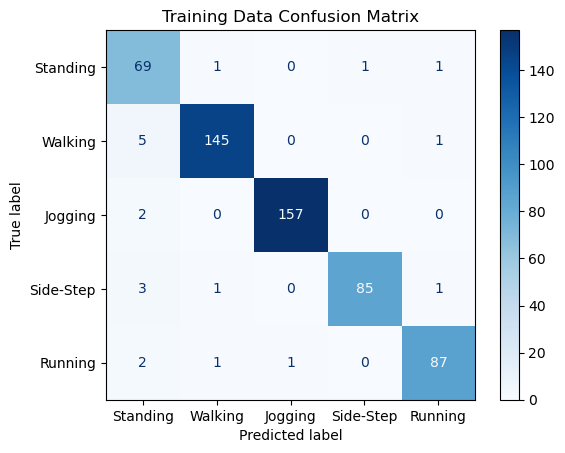

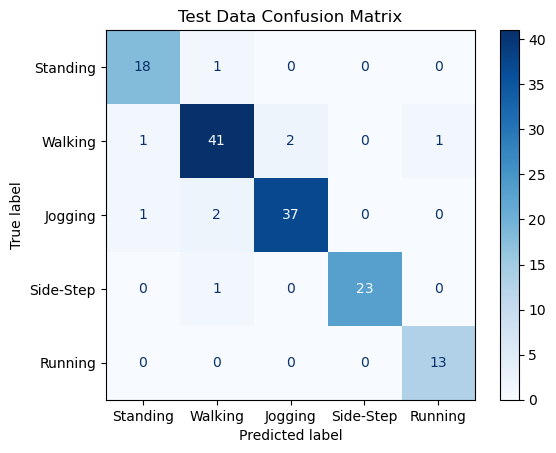

In [29]:
# Plot the confusion matrices
fig, ax = plt.subplots()
plot_confusion_matrix(best_clf, X_train, y_train,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,ax=ax)
ax.set_title('Training Data Confusion Matrix')

fig, ax = plt.subplots()
plot_confusion_matrix(best_clf, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,ax=ax)
ax.set_title('Test Data Confusion Matrix')

In [31]:
y_score = best_clf.decision_function(X_test)

# format the y_test into a n_samples x 5 binary array that indicates class membership
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4]) 

# Plot a ROC curve and calculate the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

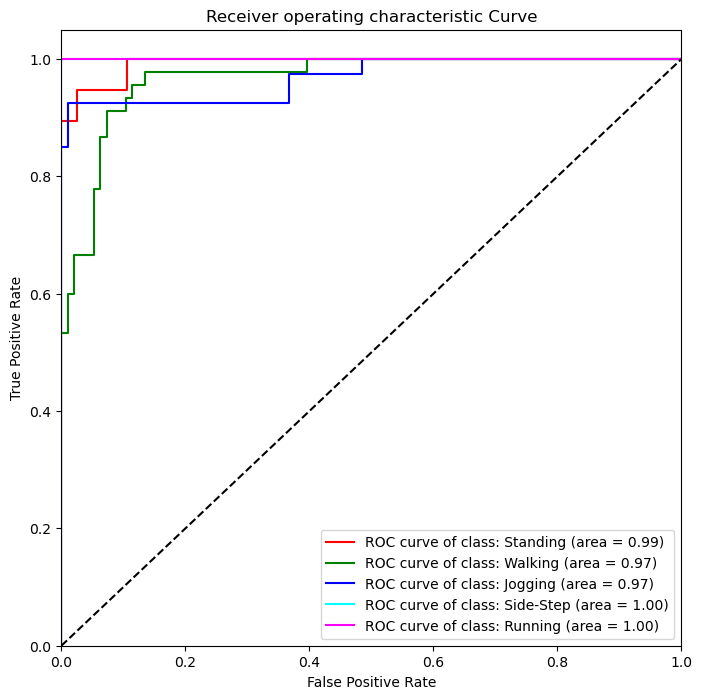

In [32]:
# Plot the TPR vs FPR for each class
fig, ax = plt.subplots(figsize=(8,8))
colors = ['red', 'green', 'blue', 'cyan', 'magenta']
for i, color in zip(range(n_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class: {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))
    
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic Curve')
ax.legend(loc="lower right")

In [33]:
# find the most important features
importances = best_clf.coef_[0]
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# save the top 5 most important features
most_important_features = []
for f in range(5):
    most_important_features.append(feature_names[indices[f]])


Feature ranking:
1. feature min_ax (13.243866)
2. feature min_az (9.370396)
3. feature min_gz (6.889438)
4. feature mu_gz (6.677989)
5. feature min_gy (5.215979)
6. feature min_gx (3.538908)
7. feature mu_az (1.522788)
8. feature mu_gy (-0.569900)
9. feature max_gz (-0.577636)
10. feature mu_ax (-0.948068)
11. feature max_ay (-2.021370)
12. feature mu_gx (-2.915639)
13. feature min_ay (-4.192351)
14. feature a_sma (-5.074634)
15. feature max_ax (-5.412106)
16. feature mu_ay (-5.751428)
17. feature g_sma (-6.807627)
18. feature max_az (-7.529580)
19. feature a_av_intensity (-8.878098)
20. feature max_gy (-9.780732)
21. feature max_gx (-10.644069)
22. feature g_av_intensity (-11.159888)


In [34]:
# set up the data to use the seaborn pairplot function

import pandas as pd

df = pd.DataFrame(X_test, columns=[feature_names[i-1] for i in range(1, 23)])
df['Target'] = y_test

# set target names
df['Target'] = df['Target'].replace(0, 'Standing')
df['Target'] = df['Target'].replace(1, 'Walking')
df['Target'] = df['Target'].replace(2, 'Jogging')
df['Target'] = df['Target'].replace(3, 'Side-Step')
df['Target'] = df['Target'].replace(4, 'Running')


df.head()

,mu_ax,mu_ay,mu_az,mu_gx,mu_gy,mu_gz,max_ax,max_ay,max_az,max_gx,...,min_ay,min_az,min_gx,min_gy,min_gz,a_sma,g_sma,a_av_intensity,g_av_intensity,Target
0,1.403807,-0.307560,0.821068,-0.841899,0.481826,-0.476511,0.702462,0.157961,0.786122,1.332839,...,0.273043,0.300684,-0.093772,-0.357498,0.221500,0.026039,0.358050,-0.015658,0.218952,Jogging
1,-0.177684,-0.347058,-0.494465,0.793596,-0.292314,-0.273571,-0.673151,-0.213166,-0.491546,-0.716399,...,0.015571,0.554673,0.265105,0.207794,0.666910,-0.485422,-0.226331,-0.576291,-0.335408,Walking
2,-0.314333,-1.036313,-0.553398,-0.524198,-0.744380,0.186010,-0.776123,-0.541299,-0.783753,-0.854389,...,0.684998,0.239509,0.939423,0.582894,0.694075,-0.661673,-0.694256,-0.777357,-0.753275,Walking
3,1.142392,-1.003086,0.109585,0.077244,-0.018933,-0.084950,0.269525,0.127805,0.134688,0.874695,...,0.255555,0.670053,0.137875,-0.322026,0.205098,-0.482268,0.075610,-0.221201,-0.003787,Jogging
4,0.156905,-0.539316,0.472770,-0.055460,0.064083,0.114453,-1.339908,-1.696779,-1.399800,-1.647411,...,1.996648,1.221912,1.785283,1.730837,1.374747,-1.117016,-2.011880,-1.089865,-1.895494,Standing


Text(0.5, 1.05, 'Pairplot of the 5 most important features for SGD Classifier')

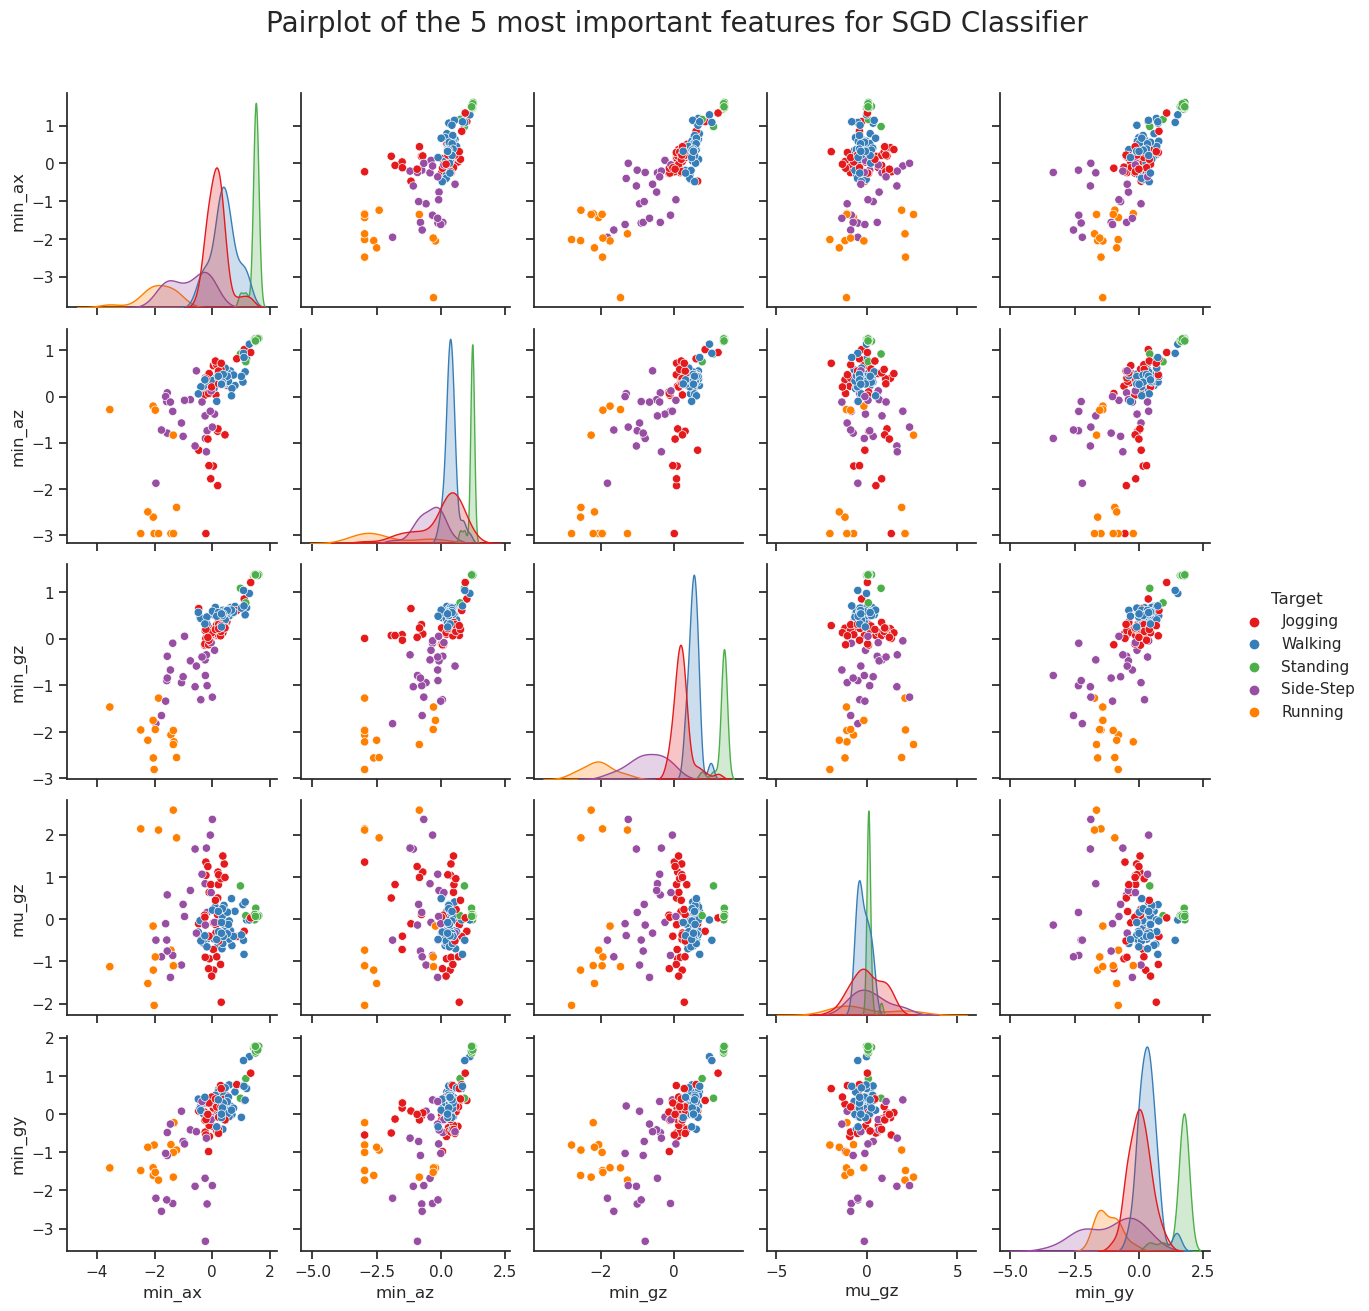

In [35]:
# pairplot the top 5 most important features

import seaborn as sns
sns.set(style="ticks", color_codes=True)

sns.pairplot(df, hue='Target', palette="Set1", diag_kind="kde", height=2.5, vars=most_important_features)
# set the pairplot title
plt.suptitle('Pairplot of the 5 most important features for SGD Classifier', y=1.05, fontsize=20)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


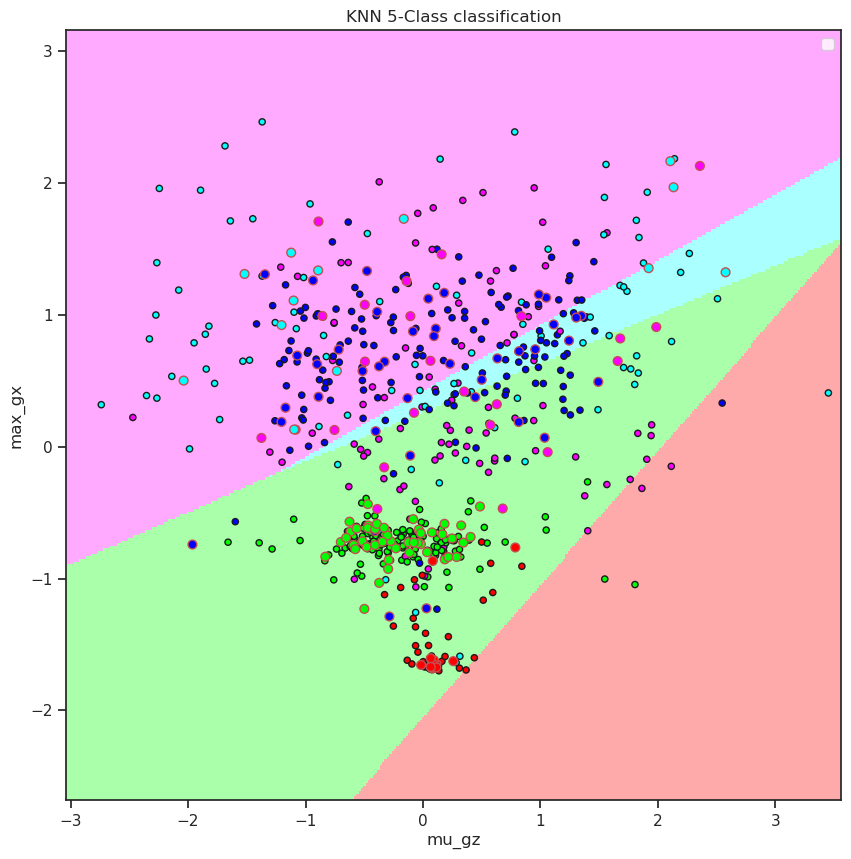

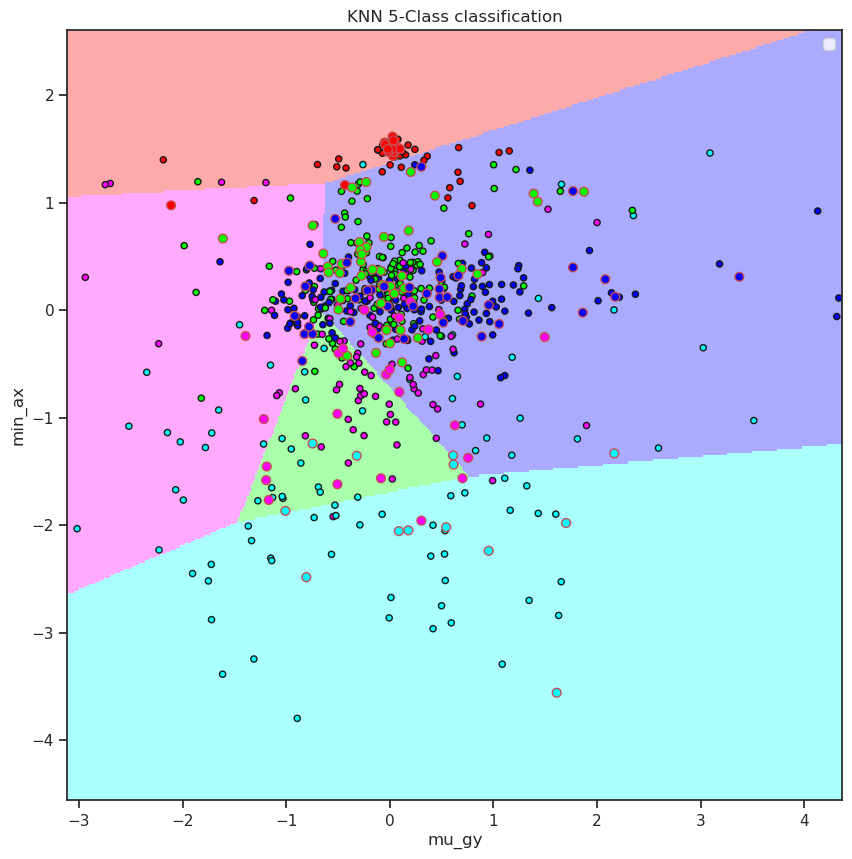

In [36]:

def plotSGDPair(f1, f2):

  X = X_test[:, [f1, f2]] # pick features 6 and 10
  y = y_test

  h = .02  # step size in the mesh

  clf = SGDClassifier(alpha=best_alpha, random_state=42)

  clf.fit(X, y)

  # Create color maps
  cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFAAFF', '#AAFFFF'])
  cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#FF00FF', '#00FFFF'])


  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  fig, ax = plt.subplots(figsize=(10,10))
  ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


  # Plot the training points
  ax.scatter(X_train[:, f1], X_train[:, f2], c=y_train, cmap=cmap_bold,
              edgecolor='k', s=20)

  # Plot the testing points
  ax.scatter(X_test[:, f1], X_test[:, f2], c=y_test, cmap=cmap_bold,
              edgecolor='r', s=40)
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  ax.set_title("KNN 5-Class classification")
  ax.set_xlabel(feature_names[f1])
  ax.set_ylabel(feature_names[f2])
  ax.legend()

plotSGDPair(5, 9)
plotSGDPair(4, 12)
